In [2]:
#import some necessary librairies
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import random
import math
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
bike_final = pd.read_csv('bike_final.csv')

In [4]:
bike_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5712065 entries, 0 to 5712064
Data columns (total 29 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   started_at                 object 
 1   ended_at                   object 
 2   start_station_name         object 
 3   end_station_name           object 
 4   lat_start                  float64
 5   lng_start                  float64
 6   lat_end                    float64
 7   lng_end                    float64
 8   Year                       int64  
 9   Month                      int64  
 10  Season                     int64  
 11  DayofMonth                 int64  
 12  DayofWeek                  int64  
 13  Is_weekend                 int64  
 14  Hour                       int64  
 15  Ride_Duration              int64  
 16  Ride_Duration_Category     int64  
 17  Ride_distance_km           float64
 18  Ride_distance_category     int64  
 19  nearest_distance_km        float64
 20  ne

In [5]:
forecast = bike_final.groupby(['Year', 'Month', 'Season', 'DayofMonth','DayofWeek','Is_weekend','Hour',
                               'Temp','Atemp','Prec','Humidity','Windspeed','AtmPressure']).size().reset_index(name='Count')
print(forecast.shape)
forecast.head()

(10934, 14)


,Year,Month,Season,DayofMonth,DayofWeek,Is_weekend,Hour,Temp,Atemp,Prec,Humidity,Windspeed,AtmPressure,Count
0,2023,1,3,1,7,1,0,2.37,3.966667,0.30,91.06,4.70,98.96,229
1,2023,1,3,1,7,1,1,2.31,3.966667,0.60,92.69,4.95,98.93,317
2,2023,1,3,1,7,1,2,2.36,3.966667,0.65,94.56,5.70,98.89,276
3,2023,1,3,1,7,1,3,2.51,3.966667,0.34,95.31,5.67,98.85,44
4,2023,1,3,1,7,1,4,2.68,3.966667,0.11,95.81,5.48,98.83,30


In [6]:
# Create a column 'DATE_TIME' as the concatenation of 'YEAR', 'MO', 'DY', 'HR'
forecast['timestamp'] = forecast['Year'].astype(str) + '-' + forecast['Month'].astype(str) + '-' + forecast['DayofMonth'].astype(str) + '-' + forecast['Hour'].astype(str)
# Convert 'DATE_TIME' to datetime format
forecast['timestamp'] = pd.to_datetime(forecast['timestamp'], format='%Y-%m-%d-%H')

forecast["timestamp"] = pd.to_datetime(forecast["timestamp"])
forecast = forecast.set_index("timestamp")
forecast.head()

,Year,Month,Season,DayofMonth,DayofWeek,Is_weekend,Hour,Temp,Atemp,Prec,Humidity,Windspeed,AtmPressure,Count
timestamp,,,,,,,,,,,,,,
2023-01-01 00:00:00,2023,1,3,1,7,1,0,2.37,3.966667,0.30,91.06,4.70,98.96,229
2023-01-01 01:00:00,2023,1,3,1,7,1,1,2.31,3.966667,0.60,92.69,4.95,98.93,317
2023-01-01 02:00:00,2023,1,3,1,7,1,2,2.36,3.966667,0.65,94.56,5.70,98.89,276
2023-01-01 03:00:00,2023,1,3,1,7,1,3,2.51,3.966667,0.34,95.31,5.67,98.85,44
2023-01-01 04:00:00,2023,1,3,1,7,1,4,2.68,3.966667,0.11,95.81,5.48,98.83,30


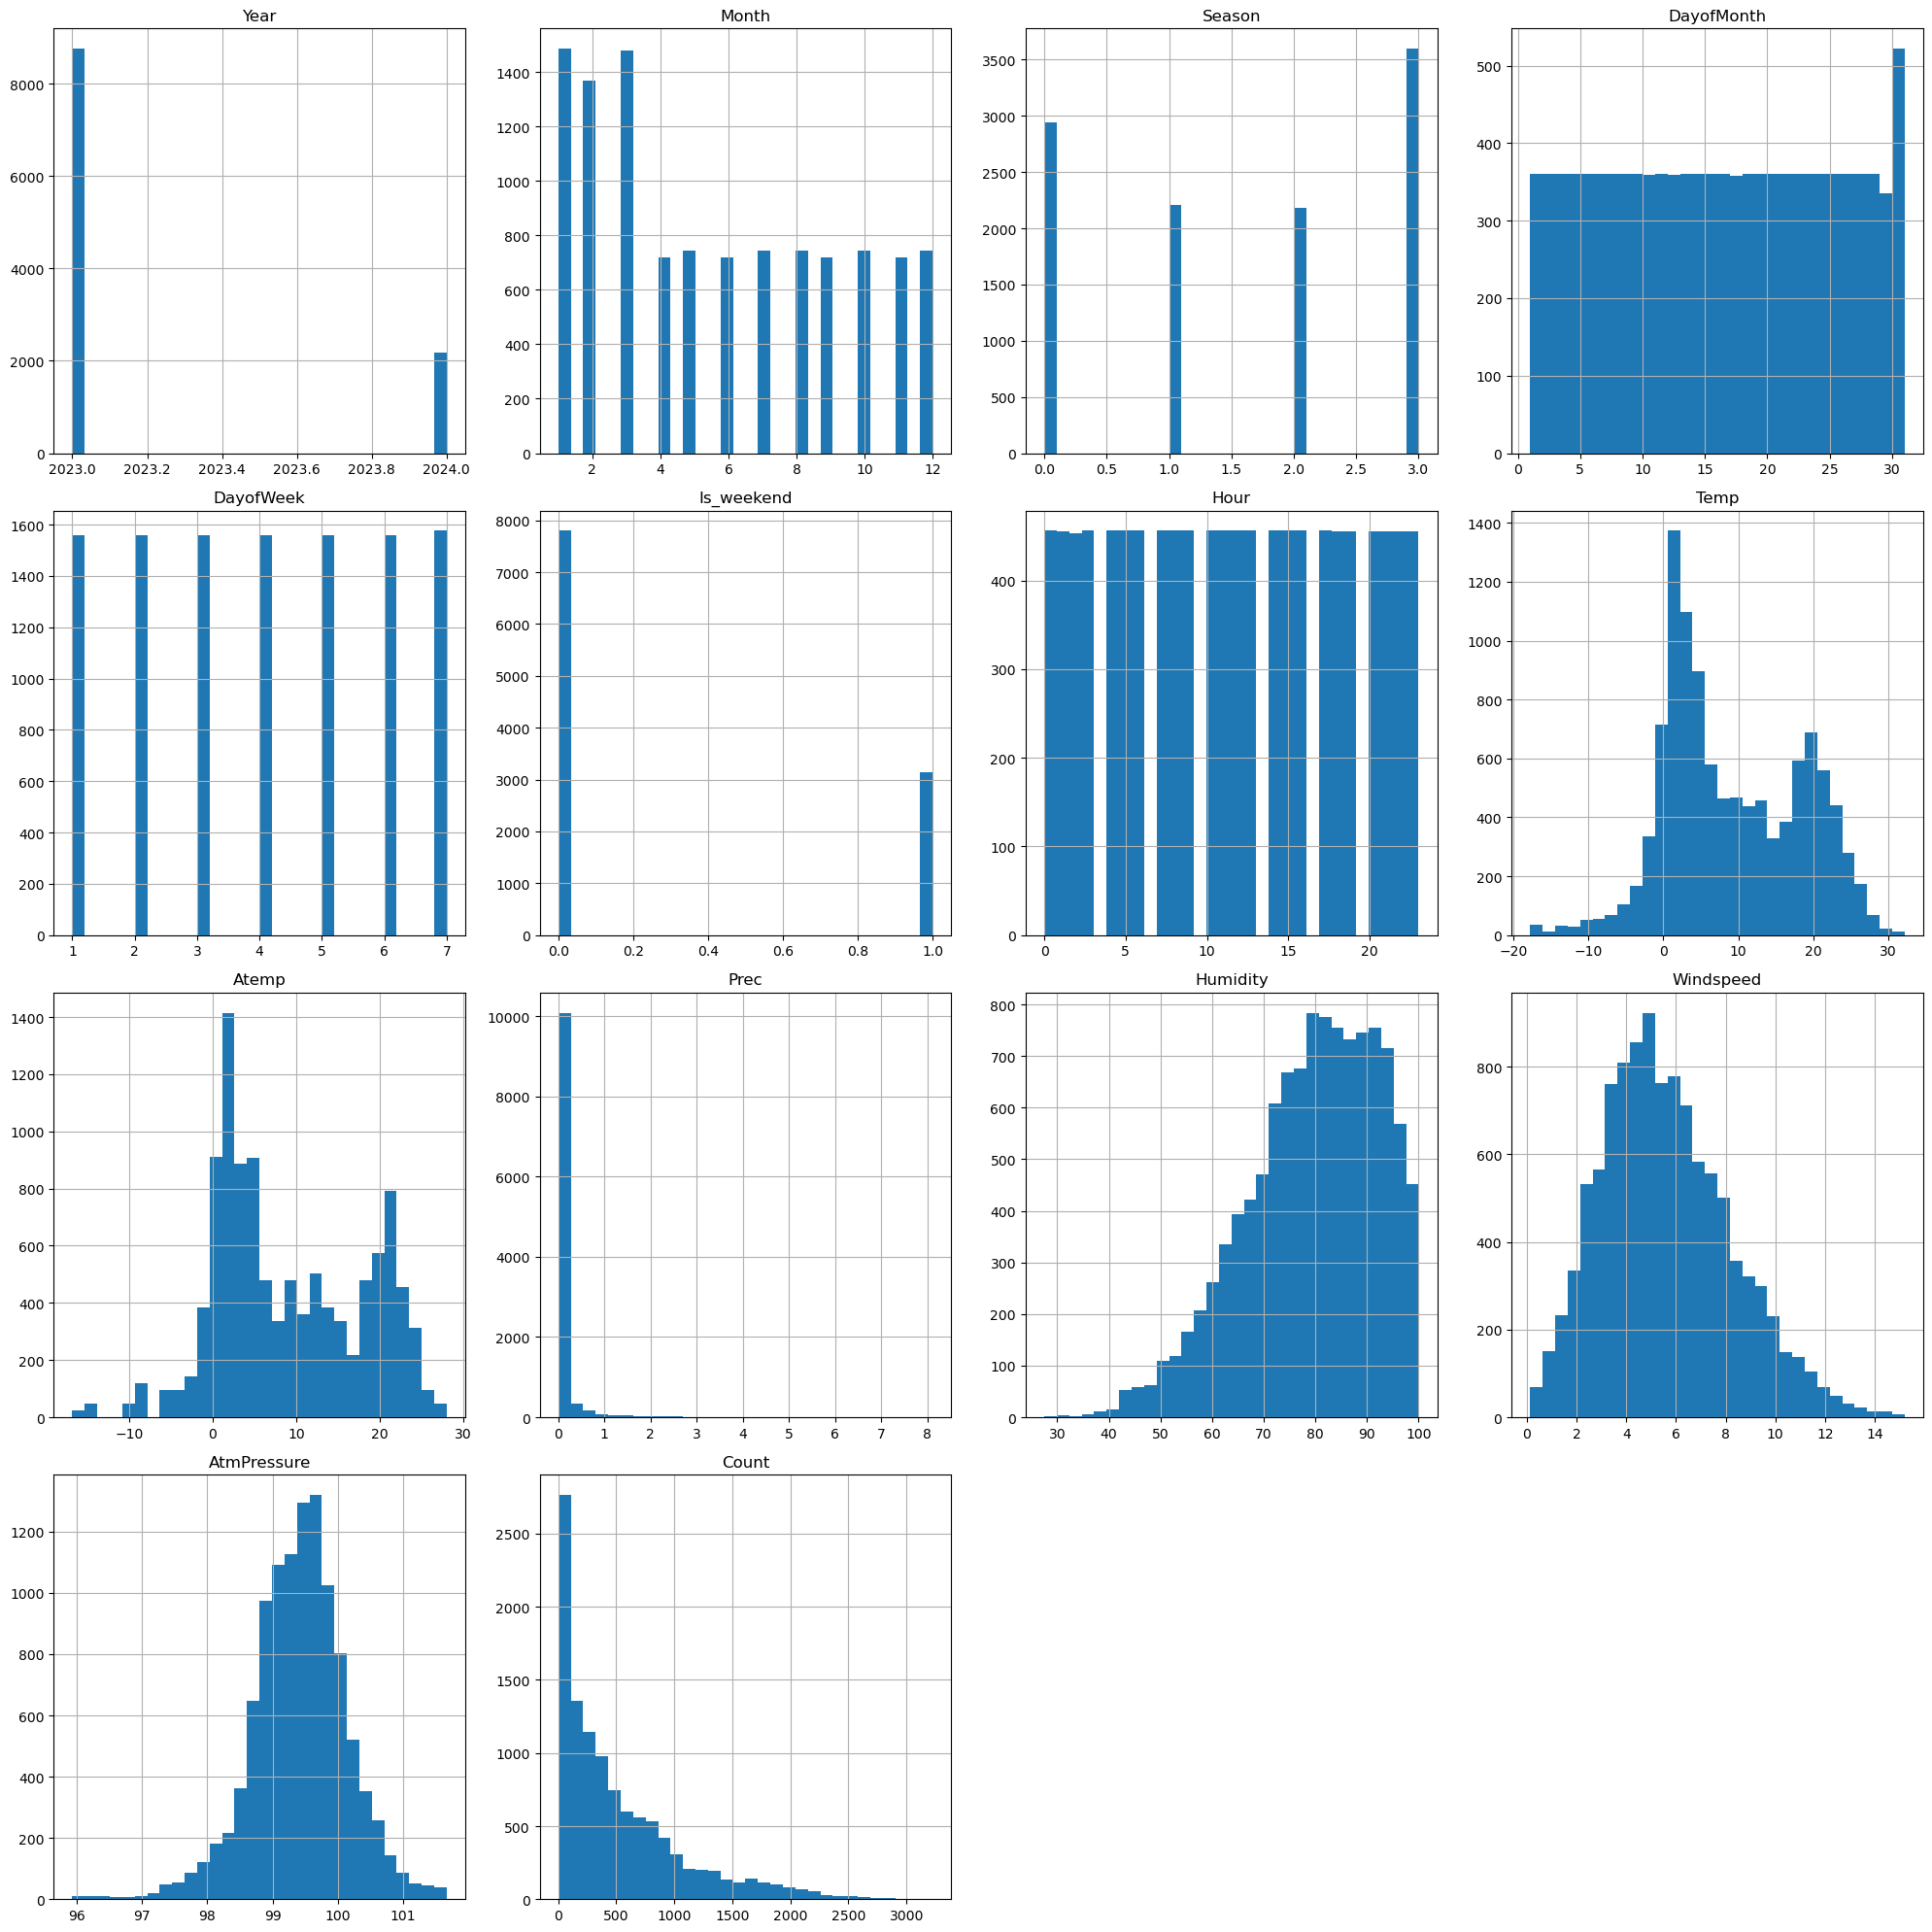

In [7]:
forecast.hist(figsize=(20, 20),bins=30)
plt.tight_layout()
plt.savefig('figure/Fig 11.png', dpi=300)
plt.show()

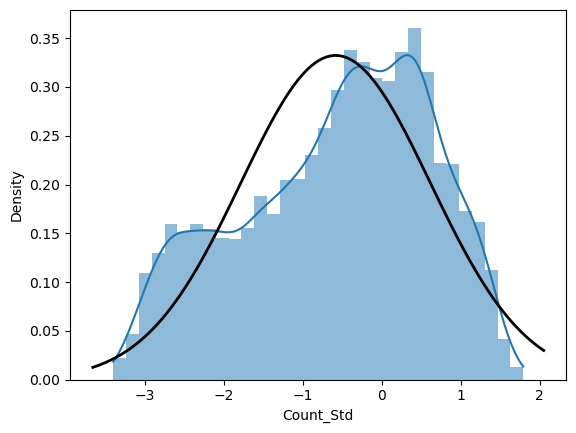

In [8]:
# Create a binary feature where 1 represents rain and 0 represents no rain
forecast['Is_rain'] = (forecast['Prec'] > 0).astype(int)

#standardisation
scaler = StandardScaler()
count_values = forecast['Count'].values.reshape(-1, 1)
count_standardized = scaler.fit_transform(count_values)
forecast['Count_Std'] = count_standardized

#Logarithmic transformation to bring the data closer to a normal distribution
forecast["Count_Std"] = np.log1p(forecast["Count_Std"])

# plot
sns.histplot(forecast['Count_Std'], kde=True, stat="density", linewidth=0)
# Fit the normal distribution to 'Count' and plot it
(mu, sigma) = norm.fit(forecast['Count_Std'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [9]:
# Demand lag feature
forecast['Count_Std_lag1hr'] = forecast['Count_Std'].shift(1)
forecast['Count_Std_lag1d'] = forecast['Count_Std'].shift(24)
forecast['Count_Std_lag1wk'] = forecast['Count_Std'].shift(24*7) 
# Weather lag feature
forecast['Temp_future1hr'] = forecast['Temp'].shift(-1) 
forecast['Is_rain_future1hr'] = forecast['Is_rain'].shift(-1) 

# Fill in missing values using before and after values
forecast.fillna(method='ffill', inplace=True)
forecast.fillna(method='bfill', inplace=True)

In [10]:
forecast_pre = forecast[['Year', 'Month', 'Season', 'DayofMonth','DayofWeek','Is_weekend','Hour',
                        'Temp','Temp_future1hr','Atemp','Is_rain','Is_rain_future1hr','Humidity','Windspeed','AtmPressure',
                        'Count_Std_lag1hr','Count_Std_lag1d','Count_Std_lag1wk','Count_Std']]
forecast_pre.head()

,Year,Month,Season,DayofMonth,DayofWeek,Is_weekend,Hour,Temp,Temp_future1hr,Atemp,Is_rain,Is_rain_future1hr,Humidity,Windspeed,AtmPressure,Count_Std_lag1hr,Count_Std_lag1d,Count_Std_lag1wk,Count_Std
timestamp,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,2023,1,3,1,7,1,0,2.37,2.31,3.966667,1,1.0,91.06,4.70,98.96,-0.785004,-0.785004,-0.785004,-0.785004
2023-01-01 01:00:00,2023,1,3,1,7,1,1,2.31,2.36,3.966667,1,1.0,92.69,4.95,98.93,-0.785004,-0.785004,-0.785004,-0.479266
2023-01-01 02:00:00,2023,1,3,1,7,1,2,2.36,2.51,3.966667,1,1.0,94.56,5.70,98.89,-0.479266,-0.785004,-0.785004,-0.610206
2023-01-01 03:00:00,2023,1,3,1,7,1,3,2.51,2.68,3.966667,1,1.0,95.31,5.67,98.85,-0.610206,-0.785004,-0.785004,-2.178649
2023-01-01 04:00:00,2023,1,3,1,7,1,4,2.68,2.74,3.966667,1,1.0,95.81,5.48,98.83,-2.178649,-0.785004,-0.785004,-2.439053


In [15]:
forecast_pre.to_csv('model/forecast_pre.csv', index=True)

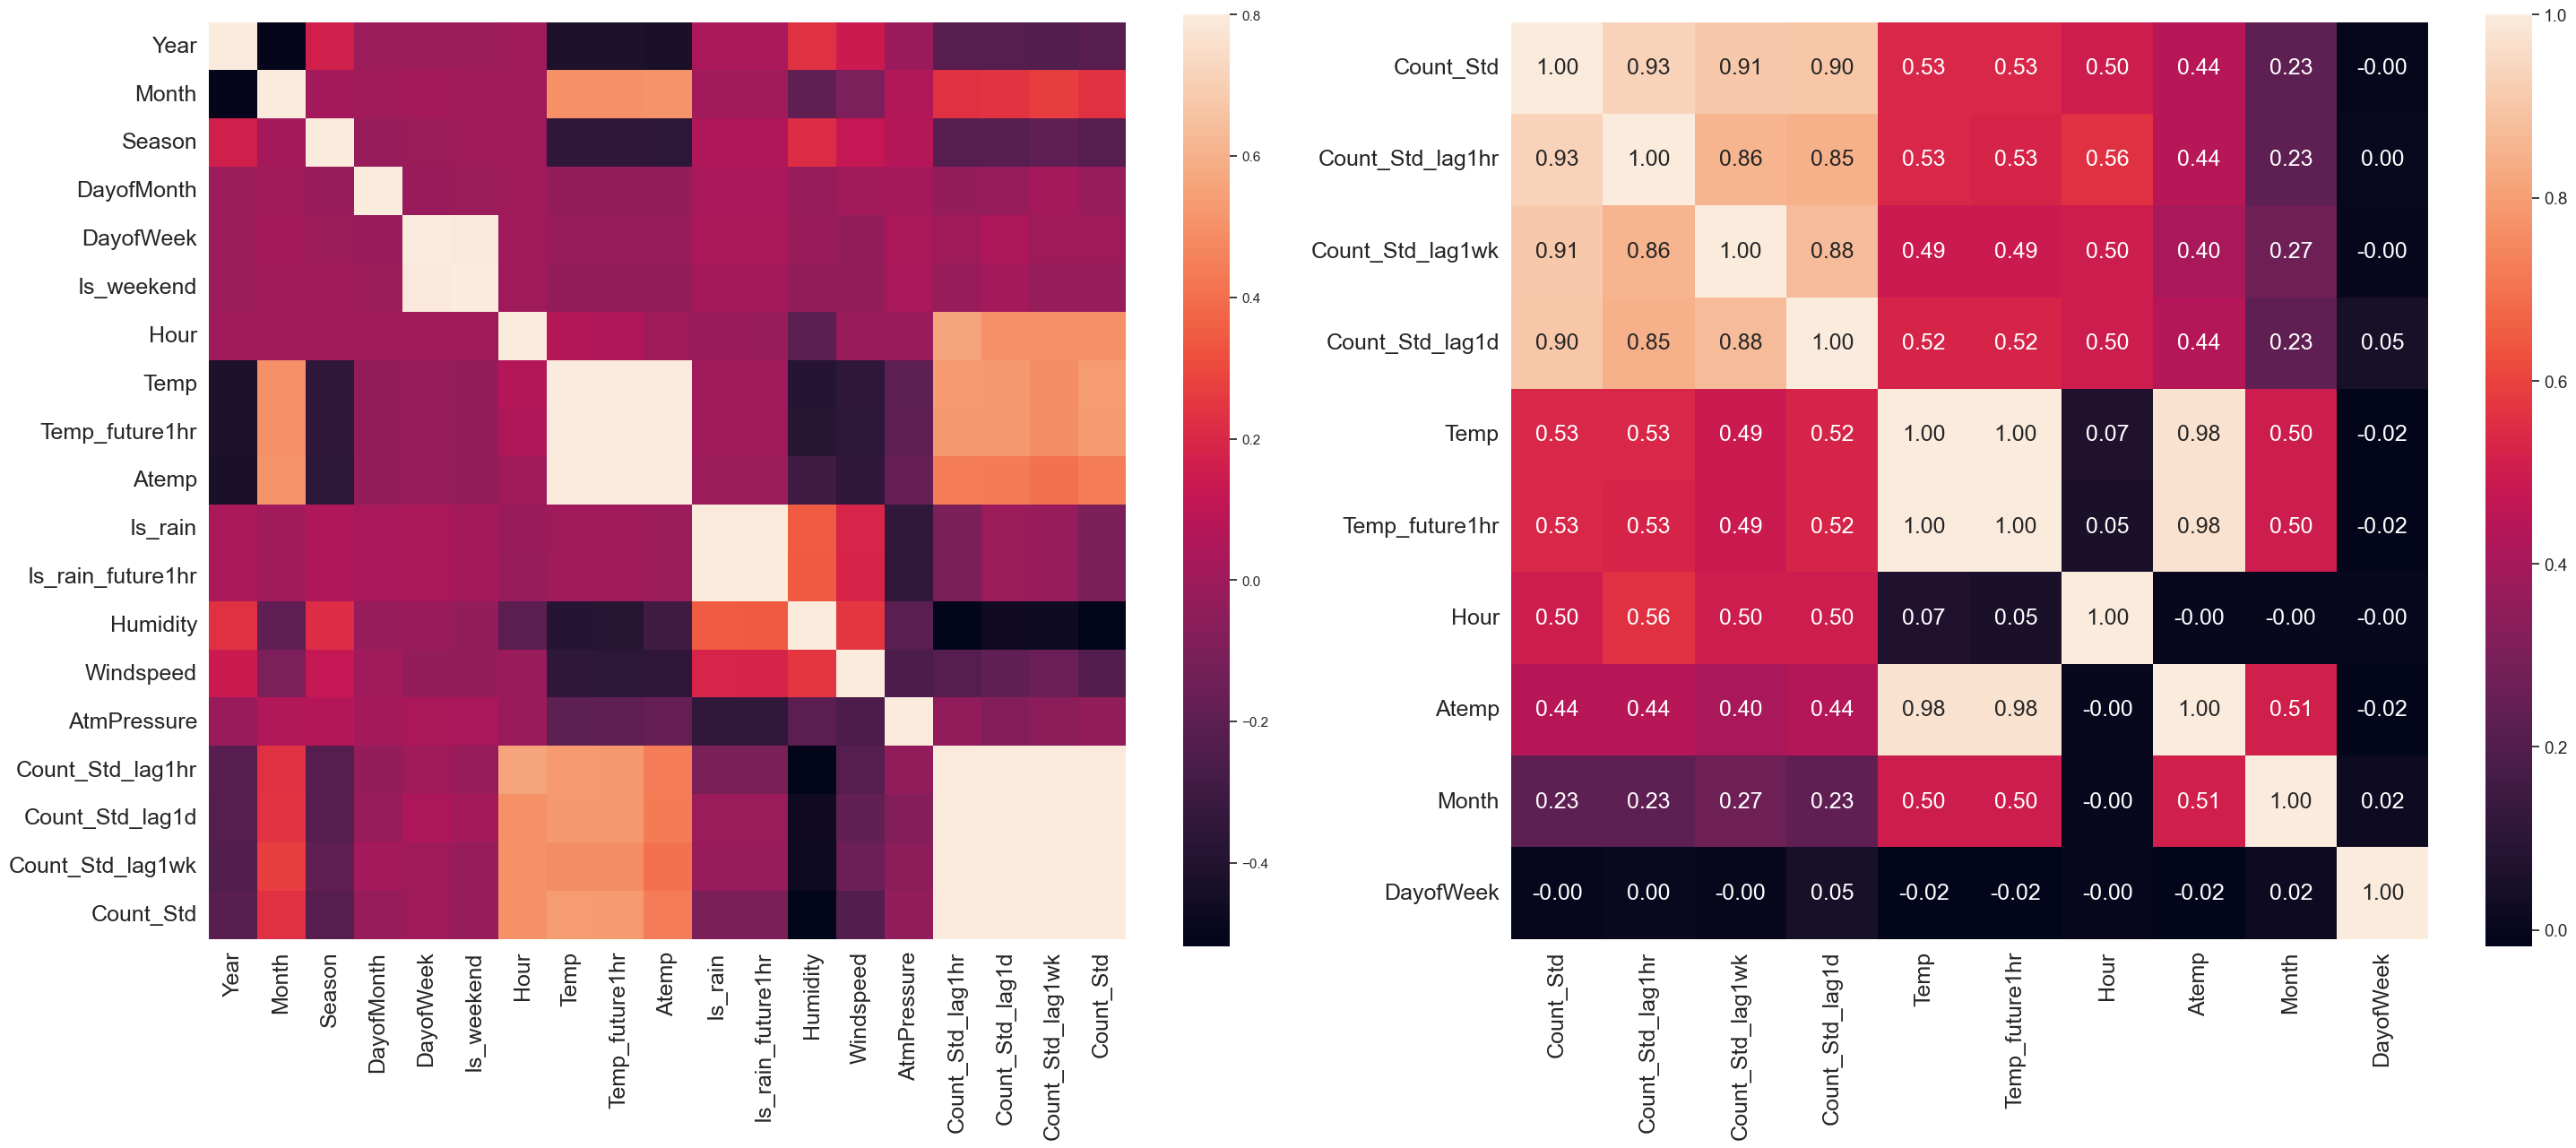

In [11]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(30, 15))

#correlation
numeric_columns = forecast_pre.select_dtypes(include=['number'])
corrmat = numeric_columns.corr()
sns.heatmap(corrmat, vmax=.8, square=True, ax=axes[0], cbar_kws={"shrink": 0.75})
for label in axes[0].get_xticklabels():
    label.set_size(18)
for label in axes[0].get_yticklabels():
    label.set_size(18)
    
#Top 10 correlations with Count
k = 10
cols = corrmat.nlargest(k, 'Count_Std')['Count_Std'].index
cm = forecast[cols].corr()
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 18}, 
            yticklabels=cols.values, xticklabels=cols.values, ax=axes[1], cbar_kws={"shrink": 0.75})
for label in axes[1].get_xticklabels():
    label.set_size(18)
for label in axes[1].get_yticklabels():
    label.set_size(18)

plt.tight_layout()
plt.savefig('figure/Fig 12.png', dpi=300)
plt.show()

In [12]:
#before OneHotEncoder
before_dummy_df = forecast_pre.copy()
before_dummy_df.to_csv('model/before_dummy_df.csv', index=True)

In [13]:
#after OneHotEncoder
columns_to_encoding = ['Year','Month','Season','DayofWeek','Is_weekend','Is_rain','Is_rain_future1hr']
dummy_df = pd.get_dummies(forecast_pre, columns=columns_to_encoding, drop_first=False)
dummy_df.to_csv('model/dummy_df.csv', index=True)
dummy_df.head()

,DayofMonth,Hour,Temp,Temp_future1hr,Atemp,Humidity,Windspeed,AtmPressure,Count_Std_lag1hr,Count_Std_lag1d,...,DayofWeek_4,DayofWeek_5,DayofWeek_6,DayofWeek_7,Is_weekend_0,Is_weekend_1,Is_rain_0,Is_rain_1,Is_rain_future1hr_0.0,Is_rain_future1hr_1.0
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,1,0,2.37,2.31,3.966667,91.06,4.70,98.96,-0.785004,-0.785004,...,False,False,False,True,False,True,False,True,False,True
2023-01-01 01:00:00,1,1,2.31,2.36,3.966667,92.69,4.95,98.93,-0.785004,-0.785004,...,False,False,False,True,False,True,False,True,False,True
2023-01-01 02:00:00,1,2,2.36,2.51,3.966667,94.56,5.70,98.89,-0.479266,-0.785004,...,False,False,False,True,False,True,False,True,False,True
2023-01-01 03:00:00,1,3,2.51,2.68,3.966667,95.31,5.67,98.85,-0.610206,-0.785004,...,False,False,False,True,False,True,False,True,False,True
2023-01-01 04:00:00,1,4,2.68,2.74,3.966667,95.81,5.48,98.83,-2.178649,-0.785004,...,False,False,False,True,False,True,False,True,False,True


Modelling

In [14]:
# Split train and test sets
train = dummy_df.loc['2023']
test = dummy_df.loc['2024']

train_X = train.drop(['Count_Std'],axis=1)
test_X = test.drop(['Count_Std'],axis=1)
train_Y = train['Count_Std']
test_Y = test['Count_Std']

In [15]:
# Lasso model
model_lasso = Lasso()
params = {'alpha': [0.1, 1, 10, 100, 1000]}
grid_search_lasso = GridSearchCV(model_lasso, params, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(train_X, train_Y)
best_params_lasso = grid_search_lasso.best_params_
model_lasso = grid_search_lasso.best_estimator_
preds_lasso = model_lasso.predict(test_X)  # Ensure prediction is from the Lasso model

# Random Forest model
model_rf = RandomForestRegressor()
params_rf = {
    'n_estimators': [10, 30, 50], 'max_features': [10, 20, 30, 40, 42]}
grid_search_rf = GridSearchCV(model_rf, params_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(train_X, train_Y)
best_params_rf = grid_search_rf.best_params_
model_rf = grid_search_rf.best_estimator_
preds_rf = model_rf.predict(test_X)

# XGBoost model
model_xgb = XGBRegressor()
params_xgb = {
    'n_estimators': [50, 100, 150], 'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.01, 0.001]}
grid_search_xgb = GridSearchCV(model_xgb, params_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(train_X, train_Y)
best_params_xgb = grid_search_xgb.best_params_
model_xgb = grid_search_xgb.best_estimator_
preds_xgb = model_xgb.predict(test_X)

# print the best parameters found for each model
print("Best parameters for Lasso:", best_params_lasso)
print("Best parameters for Random Forest:", best_params_rf)
print("Best parameters for XGBoost:", best_params_xgb)

Best parameters for Lasso: {'alpha': 0.1}
Best parameters for Random Forest: {'max_features': 30, 'n_estimators': 50}
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}


In [16]:
#LSTM - split train
training_data_len = 8759
testing_data_len = len(dummy_df) - training_data_len
time_steps = 24
train_lstm, test_lstm = dummy_df.iloc[0:training_data_len], dummy_df.iloc[(training_data_len-time_steps):len(dummy_df)]
print(dummy_df.shape, train_lstm.shape, test_lstm.shape)

# Scale the all of the data from columns ['t1', 't2', 'hum', 'wind_speed']
train_trans = train_lstm[['Temp', 'Temp_future1hr','Atemp','Humidity', 'Windspeed','AtmPressure']].to_numpy()
test_trans = test_lstm[['Temp', 'Temp_future1hr','Atemp','Humidity', 'Windspeed','AtmPressure']].to_numpy()
scaler = RobustScaler() # Handles outliers
train_lstm.loc[:, ['Temp', 'Temp_future1hr','Atemp','Humidity', 'Windspeed','AtmPressure']]=scaler.fit_transform(train_trans)
test_lstm.loc[:, ['Temp', 'Temp_future1hr','Atemp','Humidity', 'Windspeed','AtmPressure']]=scaler.fit_transform(test_trans)

#Split the data into x_train and y_train data sets
x_train_lstm = []
y_train_lstm = []
for i in tqdm(range(len(train_lstm) - time_steps)):
    x_train_lstm.append(train_lstm.drop(columns='Count_Std').iloc[i:i + time_steps].to_numpy())
    y_train_lstm.append(train_lstm.loc[:,'Count_Std'].iloc[i + time_steps])
#Convert x_train and y_train to numpy arrays
x_train_lstm = np.array(x_train_lstm)
y_train_lstm = np.array(y_train_lstm)

#Create the x_test and y_test data sets
x_test_lstm = []
y_test_lstm = dummy_df.loc[:,'Count_Std'].iloc[training_data_len:len(dummy_df)]
for i in tqdm(range(len(test_lstm) - time_steps)):
    x_test_lstm.append(test_lstm.drop(columns='Count_Std').iloc[i:i + time_steps].to_numpy())
#Convert x_test and y_test to numpy arrays
x_test_lstm = np.array(x_test_lstm)
y_test_lstm = np.array(y_test_lstm)

print('Train size:')
print(x_train_lstm.shape, y_train_lstm.shape)
print('Test size:')
print(x_test_lstm.shape, y_test_lstm.shape)

(10934, 43) (8759, 43) (2199, 43)


  0%|          | 0/8735 [00:00<?, ?it/s]

  0%|          | 0/2175 [00:00<?, ?it/s]

Train size:
(8735, 24, 42) (8735,)
Test size:
(2175, 24, 42) (2175,)


In [17]:
#LSTM model
random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

# Convert the data to float32
x_train_lstm = x_train_lstm.astype('float32')
y_train_lstm = y_train_lstm.astype('float32')
x_test_lstm = x_test_lstm.astype('float32')

# Define the model
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss="mse")
# Fit the model
early_stopping = EarlyStopping(monitor='val_loss',patience=15, verbose=1,mode='min',restore_best_weights=True)
history = model.fit(x_train_lstm, y_train_lstm, epochs=100, batch_size=16, validation_split=0.1, shuffle=True, callbacks=[early_stopping])
preds_lstm = model.predict(x_test_lstm)


Epoch 1/100

492/492 [==============================] - 5s 6ms/step - loss: 0.1856 - val_loss: 0.1150
Epoch 2/100
492/492 [==============================] - 2s 5ms/step - loss: 0.1024 - val_loss: 0.1077
Epoch 3/100
492/492 [==============================] - 3s 5ms/step - loss: 0.0999 - val_loss: 0.0892
Epoch 4/100
492/492 [==============================] - 2s 5ms/step - loss: 0.0880 - val_loss: 0.1171
Epoch 5/100
492/492 [==============================] - 2s 5ms/step - loss: 0.0880 - val_loss: 0.1503
Epoch 6/100
492/492 [==============================] - 2s 5ms/step - loss: 0.0874 - val_loss: 0.1117
Epoch 7/100
492/492 [==============================] - 3s 5ms/step - loss: 0.0795 - val_loss: 0.1063
Epoch 8/100
492/492 [==============================] - 2s 5ms/step - loss: 0.0794 - val_loss: 0.0962
Epoch 9/100
492/492 [==============================] - 2s 5ms/step - loss: 0.0799 - val_loss: 0.0921
Epoch 10/100
492/492 [==============================] - 2s 5ms/step - loss: 0.0795 - val_

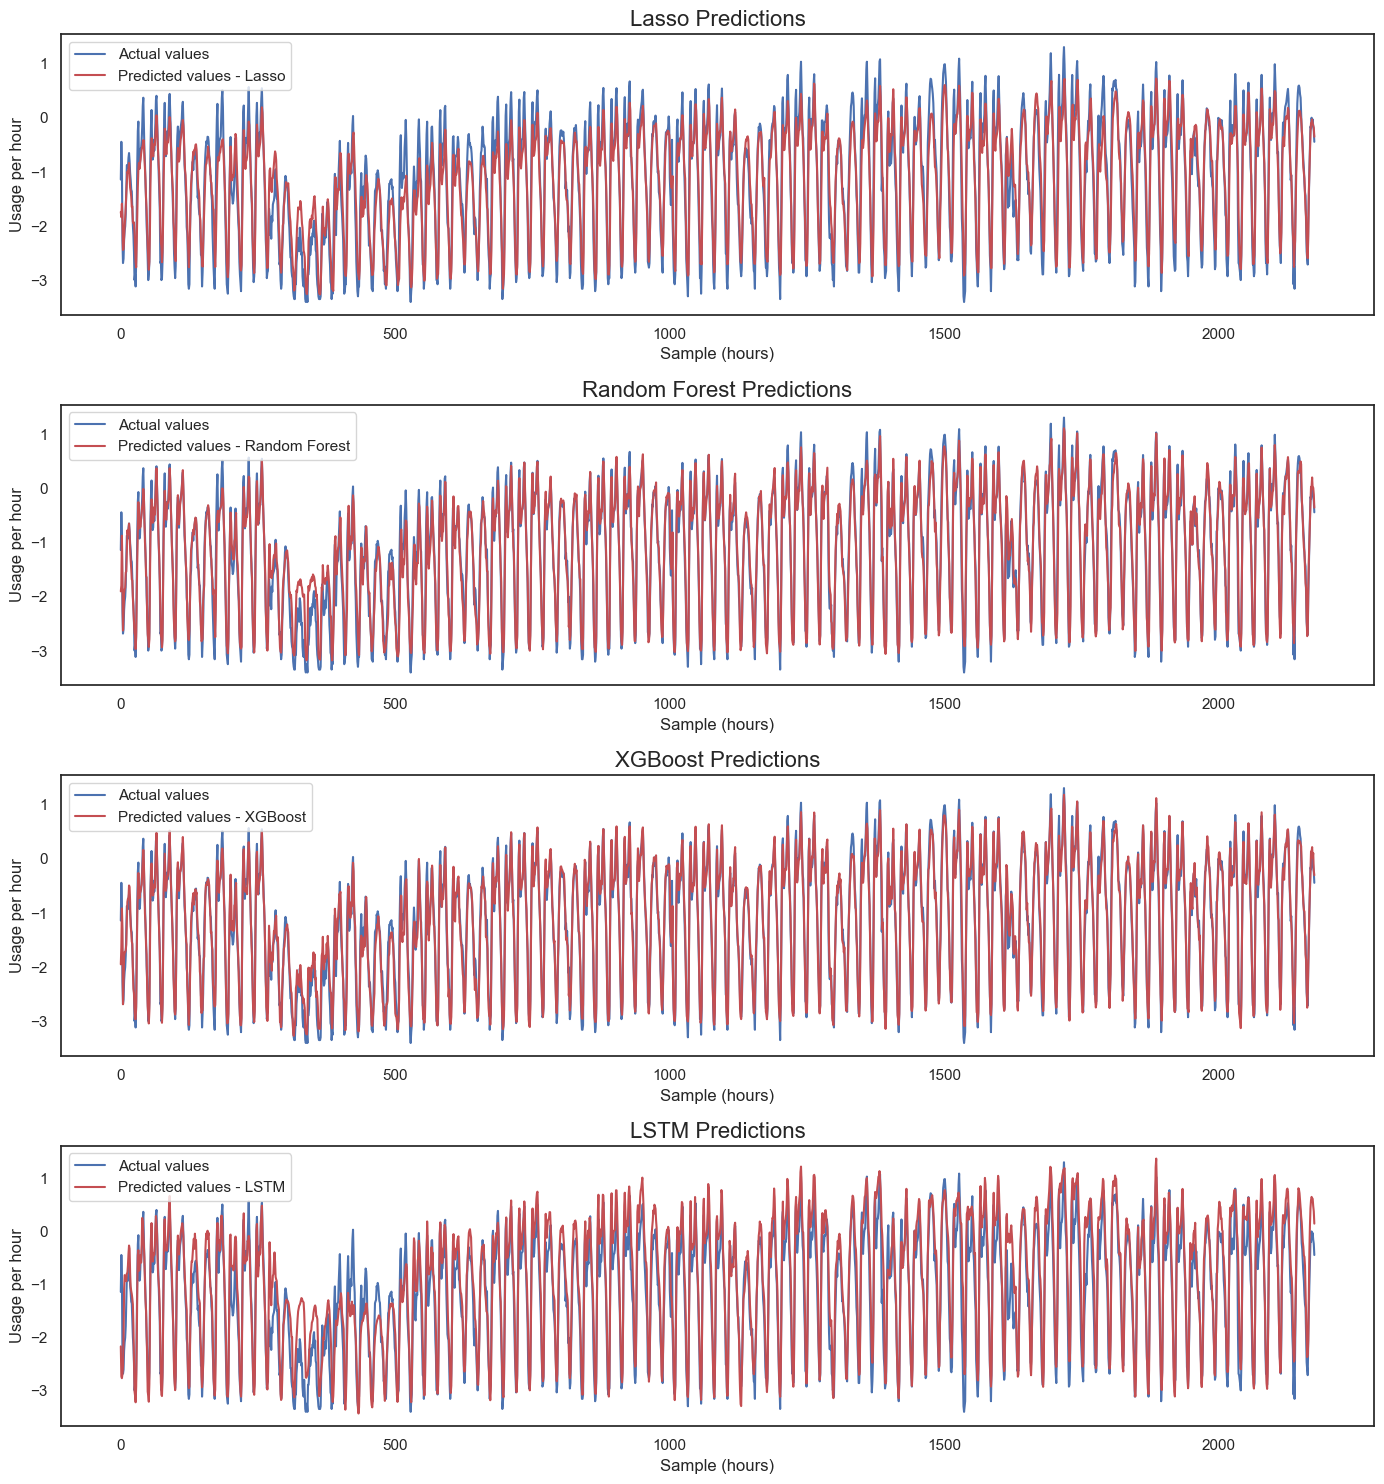

In [19]:
sns.set(style="white")
fig, axes = plt.subplots(4, 1, figsize=(14, 15))

# Lasso
axes[0].plot(test_Y.values, label='Actual')
axes[0].plot(preds_lasso, label="Predictions", color="r")
axes[0].set_xlabel('Sample (hours)')
axes[0].set_ylabel('Usage per hour')
axes[0].legend(['Actual values', 'Predicted values - Lasso'])
axes[0].set_title('Lasso Predictions', fontsize=16)

# Random Forest
axes[1].plot(test_Y.values, label='Actual')
axes[1].plot(preds_rf, label="Predictions", color="r")
axes[1].set_xlabel('Sample (hours)')
axes[1].set_ylabel('Usage per hour')
axes[1].legend(['Actual values', 'Predicted values - Random Forest'])
axes[1].set_title('Random Forest Predictions', fontsize=16)

# XGBoost
axes[2].plot(test_Y.values, label='Actual')
axes[2].plot(preds_xgb, label="Predictions", color="r")
axes[2].set_xlabel('Sample (hours)')
axes[2].set_ylabel('Usage per hour')
axes[2].legend(['Actual values', 'Predicted values - XGBoost'])
axes[2].set_title('XGBoost Predictions', fontsize=16)

# LSTM
axes[3].plot(y_test_lstm, label='Actual')
axes[3].plot(preds_lstm, label="Predictions", color="r")
axes[3].set_xlabel('Sample (hours)')
axes[3].set_ylabel('Usage per hour')
axes[3].legend(['Actual values', 'Predicted values - LSTM'])
axes[3].set_title('LSTM Predictions', fontsize=16)

plt.tight_layout()
plt.savefig('figure/Fig_13.png', dpi=300)
plt.show()

In [18]:
#Results Comparison
models = {'Lasso': preds_lasso, 'Random Forest': preds_rf, 'XGBoost': preds_xgb, 'LSTM': preds_lstm}
results_list = []
for model_name, preds in models.items():
    # Adjusting the target variable used for comparison based on the model
    actual_values = test_Y if model_name != 'LSTM' else y_test_lstm
    
    mse = mean_squared_error(actual_values, preds)
    r2 = r2_score(actual_values, preds)
    mae = mean_absolute_error(actual_values, preds)
    rmse = np.sqrt(mse)
    # Protect against division by zero error for MAPE calculation
    mape = np.mean(np.abs((actual_values - preds) / np.where(actual_values != 0, actual_values, 1))) * 100
    
    results_list.append({'Model': model_name, 'R2': r2, 'MSE': mse, 'RMSE': rmse, 'MAPE(%)': mape, 'MAE': mae})

results = pd.DataFrame(results_list)
results.to_csv('model/results.csv', index=False)
results

,Model,R2,MSE,RMSE,MAPE(%),MAE
0,Lasso,0.889552,0.134968,0.367380,143.933751,0.287172
1,Random Forest,0.950079,0.061004,0.246990,77.495268,0.176057
2,XGBoost,0.966923,0.040421,0.201049,58.674910,0.148021
3,LSTM,0.856978,0.174775,0.418061,603.380981,0.319449
